# Clasificación de Ingresos con Machine Learning para Análisis Socioeconómico

En este proyecto se desarrolla un sistema de **clasificación de ingresos personales** basado en modelos de *machine learning*, cuyo objetivo es predecir si un individuo gana **más o menos de \$50K anuales** utilizando datos demográficos y laborales extraídos del censo.

El sistema está diseñado para analizar registros individuales y, mediante un algoritmo de **clasificación supervisada**, identificar patrones socioeconómicos relevantes que puedan ser útiles en estudios de mercado, políticas públicas, o decisiones comerciales.

Adicionalmente, se contempla la posibilidad de extender el análisis para generar **visualizaciones interactivas** o aplicar técnicas de segmentación poblacional con fines estadísticos o estratégicos.

## Objetivo

- Desarrollar un modelo capaz de **predecir el nivel de ingresos** de una persona a partir de datos censales.
- Aplicar técnicas de *preprocesamiento*, *entrenamiento* y *evaluación* de modelos de clasificación binaria.
- Diseñar un pipeline reproducible que permita aplicar el modelo en nuevos conjuntos de datos.

## Alcance del Proyecto

- Exploración de datos (EDA) y visualización de variables clave.
- Entrenamiento y validación de modelos de clasificación (por ejemplo: Regresión Logística, Árboles de Decisión, Random Forest).
- Evaluación de métricas como *accuracy*, *precision*, *recall*, y *f1-score*.
- Identificación de las variables más relevantes mediante técnicas de importancia de características.

## Uso Comercial

Este tipo de análisis tiene múltiples aplicaciones prácticas en sectores como:

- **Banca y Finanzas**: Evaluación crediticia y segmentación de clientes.
- **Marketing**: Diseño de campañas según el perfil socioeconómico.
- **Gobierno y ONGs**: Políticas de inclusión y estudios poblacionales.

## Dataset Utilizado: Adult Census Income

Se utiliza el *dataset* **Adult Income (también conocido como Census Income)**, extraído del Censo de EE. UU. de 1994 y preparado por Ronny Kohavi y Barry Becker para tareas de minería de datos.

Características principales del *dataset*:

- **Número de instancias**: ~48,000 registros.
- **Atributos**: 14 variables incluyendo edad, educación, ocupación, horas trabajadas por semana, entre otros.
- **Variable objetivo**: `income`, que indica si el individuo gana `>50K` o `<=50K` al año.
- **Tipo de datos**: Mixto (categóricos y numéricos).
- **Fuente original**: Base de datos de la Oficina del Censo de los Estados Unidos.


> **Nota sobre la limpieza del dataset**:
> 
> Antes de incluir los registros en el conjunto de datos final, se aplicaron ciertos **filtros de limpieza** para asegurar que los datos sean relevantes y de calidad. Estos filtros fueron:
>
> - `AAGE > 16`: Se excluyen personas menores de 17 años, ya que generalmente no participan activamente en el mercado laboral.
> - `AGI > 100`: Aunque `AGI` no figura directamente en la versión final, este filtro garantiza que se consideren solo registros con ingresos válidos y no triviales.
> - `AFNLWGT > 1`: Se descartan registros con peso muestral casi nulo. El campo `fnlwgt` indica cuántas personas en la población representa ese registro. Si es muy bajo, el dato tiene poca relevancia estadística.
> - `HRSWK > 0`: Se omiten personas que no trabajan nada en la semana, ya que no aportan información útil al análisis de ingresos.
>
> Estos filtros ayudan a mantener un conjunto de datos limpio, útil y representativo para entrenar modelos de clasificación.


### Acceso al Dataset

El *dataset* puede descargarse desde Kaggle:

👉 [Adult Census Income Dataset en Kaggle](https://www.kaggle.com/datasets/uciml/adult-census-income)

Esta versión puede contener columnas mejor etiquetadas y separadas para análisis más avanzados o uso con frameworks como **TensorFlow**, **PyTorch** o **XGBoost**.

### Basado en investigaciones académicas

Este proyecto toma como base el trabajo académico publicado por:

> **Ron Kohavi**, “Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid”, *KDD 1996*.

Además, es ampliamente utilizado como benchmark en cursos, certificaciones y desafíos de ciencia de datos debido a su simplicidad y valor práctico.

Para este trabajo se utilizará la versión en Kaggle, por su formato limpio y accesible.

## EDA: Exploratory Data Analysis

El primer paso en este proyecto es realizar un análisis exploratorio de datos (EDA) sobre el *dataset* **Adult Census Income**. Este proceso es clave para entender la naturaleza de los datos disponibles y preparar el terreno para la fase de modelado.

A diferencia de otros *datasets* integrados en librerías como `scikit-learn`, el *Adult Income* proviene de fuentes externas (como Kaggle o UCI), y se presenta habitualmente en formato **CSV**. Por lo tanto, podemos utilizar directamente funciones como `head()`, `info()` y `describe()` de **pandas** para comenzar la exploración.

> **Nota**: Antes de aplicar modelos de machine learning, es esencial entender la distribución de los datos, la presencia de valores nulos, y las relaciones entre las variables.

### Descripción del Dataset

El *dataset* Adult Income contiene información demográfica y laboral de individuos adultos residentes en EE.UU., recolectada por la Oficina del Censo. El objetivo es predecir si el ingreso anual de una persona supera los **\$50,000**.

Una vez cargado en un `DataFrame` de `pandas`, el conjunto de datos se verá de la siguiente manera:

| Columna             | Tipo       | Descripción                                                             |
|---------------------|------------|-------------------------------------------------------------------------|
| `age`               | Numérica   | Edad del individuo.                                                    |
| `workclass`         | Categórica | Tipo de empleo (privado, gobierno, autónomo, etc.).                    |
| `fnlwgt`            | Numérica   | Peso muestral (indica cuántas personas representa esta muestra).       |
| `education`         | Categórica | Nivel educativo (HS-grad, Bachelors, etc.).                            |
| `education-num`     | Numérica   | Nivel educativo en formato numérico.                                   |
| `marital-status`    | Categórica | Estado civil.                                                           |
| `occupation`        | Categórica | Ocupación laboral.                                                     |
| `relationship`      | Categórica | Relación familiar (esposo/a, hijo/a, etc.).                            |
| `race`              | Categórica | Raza declarada.                                                        |
| `sex`               | Categórica | Género (Male/Female).                                                  |
| `capital-gain`      | Numérica   | Ganancias de capital obtenidas.                                        |
| `capital-loss`      | Numérica   | Pérdidas de capital registradas.                                       |
| `hours-per-week`    | Numérica   | Cantidad de horas trabajadas por semana.                               |
| `native-country`    | Categórica | País de origen.                                                        |
| `income`            | Categórica | Variable objetivo: `>50K` o `<=50K` (clase a predecir).                |

> **Nota**: Algunas columnas como `education` y `education-num` son redundantes, pero pueden utilizarse para contrastar codificaciones.

### Carga de Datos

Los datos serán descargados directamente desde Kaggle mediante el siguiente código:

In [1]:
# Se importa la librería 'kagglehub' para permitir la descarga de datasets desde Kaggle.
import kagglehub  
import os

# Se descarga la última versión disponible del dataset "adult-census-income" desde el repositorio "uciml" en Kaggle.
path = kagglehub.dataset_download("uciml/adult-census-income")  

# Se imprime la ruta local en la que se han almacenado los archivos descargados del dataset.
print("Path to dataset files:", path)

# Mostrar todos los archivos descargados en el path del dataset
print("\nArchivos en el path:")
for file in os.listdir(path):
    print(file)


d:\seattle_pricing_model\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\George\.cache\kagglehub\datasets\uciml\adult-census-income\versions\3

Archivos en el path:
adult.csv


El siguiente paso será crear una función utilizando las librerías os y pandas con el fin de cargar los datos del dataset en formato CSV.

In [2]:
import pandas as pd

# Se crea una función para guardar los datos del dataset en un objeto
# de tipo dataframe
def load_data(path, name):
    csv_path = os.path.join(path, name)
    return pd.read_csv(csv_path)

Con la función `load_data` se cargan los datos desde el dataset y se crea un objeto de tipo `dataframe` que será llamado `census`. Posteriormente se imprimiran las primeras lineas junto con los atributos del dataset utilizando el método ``head()``, esto permitirá verificar la estructura de los datos con los se va a trabajar.

In [3]:
# Se carga el modelo y es guardado como un objeto dataframe
census = load_data(path,"adult.csv")

# Se muestran las primeras 5 lineas de dicho objeto
census.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


A simple vista se puede obervar que el dataset posee datos numérico y categóricos, tal como se describió al inicio de este documento. Además posee valores faltantes en varias de sus intancias.

### Análisis Inicial

Dentro de las opciones que ofrece la librería ``pandas``, se encuentra la posibilidad de obtener información sobre el objeto de tipo ``dataframe``, que acaba de ser creado, a través del método ``info()``.

In [4]:
# Se muestra la información del objeto
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


El método ``info()`` permite determinar que el dataset posee 32,561 entradas y 15 atributos. De estos atributos, 6 son de tipo ``int64`` (enteros) y 9 son de tipo ``object`` (categóricos o texto). Si bien ``info()`` establece que no hay datos nulos, hemos visto celdas que poseen el valor *?* lo que implica que falta información en dicho atributo para esa instancia en particular.

El siguiente paso será usar el método ``describe()`` para obtener información estadística de cada atributo numérico. Aquellos de tipo ``object`` no son tenidos en cuenta.

In [5]:
# El siguiente paso es mostrar la descripción de estadística de
# los atributos numéricos
census.describe()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Habiendo determinado las métricas básicas del dataset, analicemos la distribución de cada variable numérica

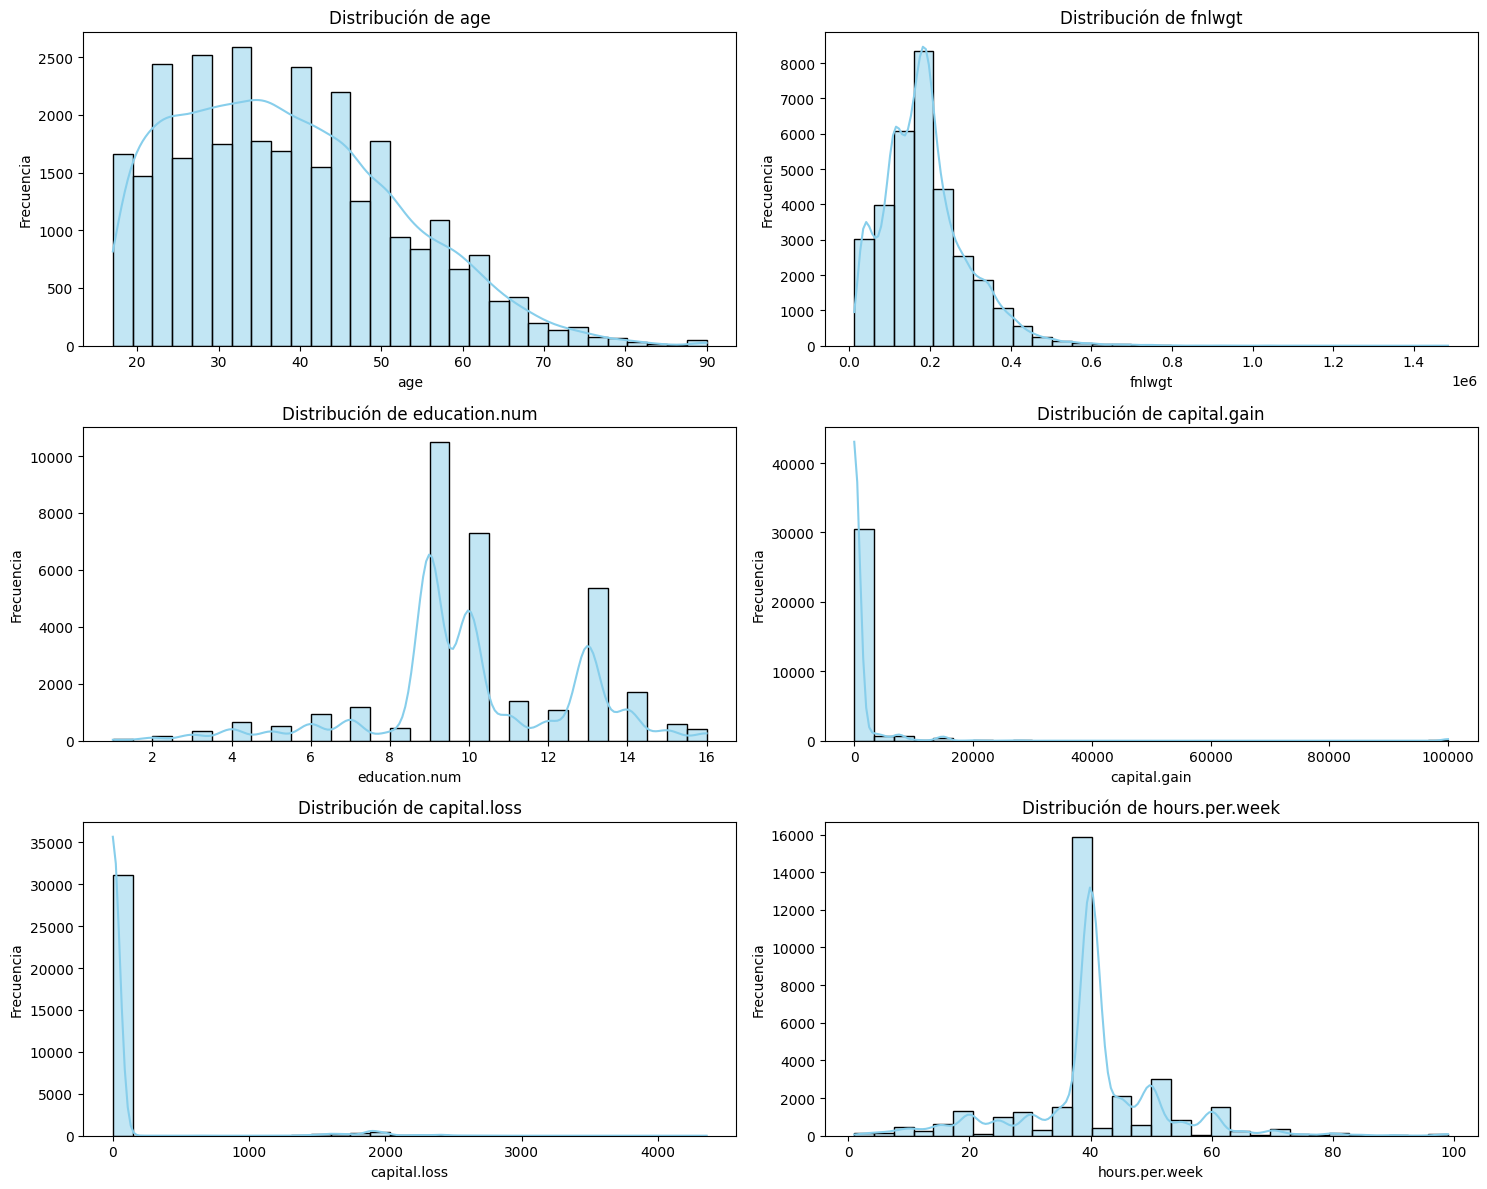

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir las variables numéricas del dataset
variables_numericas = ['age', 'fnlwgt', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

# Definir el tamaño de la figura
plt.figure(figsize=(15, 12))

# Crear un histograma para cada variable numérica
for i, var in enumerate(variables_numericas, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=census, x=var, kde=True, bins=30, color='skyblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()




El atributo ``age`` representa la edad de los individuos registrados en el dataset. Se observa que la edad mínima es de 17 años y la máxima de 90, con una media de aproximadamente 38.6 años y una desviación estándar de 13.64. Esto indica que el rango de edades es amplio y está moderadamente disperso, siendo la mediana de 37 años. La distribución muestra que al menos el 75% de los individuos tienen una edad inferior a 48 años, lo cual sugiere que se trata principalmente de una población adulta en edad productiva.

El campo ``fnlwgt``, correspondiente al peso final de la muestra, presenta una gran variabilidad, con valores que van desde 12,285 hasta 1,484,705. La media se encuentra alrededor de 189,778 y la desviación estándar es superior a 100,000, lo que indica la presencia de valores altamente dispersos. Dado que este atributo fue diseñado originalmente para ajustar la representatividad de la muestra en estudios censales, su escala no tiene una interpretación directa y puede influir de forma desproporcionada en algunos modelos si no se transforma o normaliza adecuadamente.

Respecto al atributo ``education.num``, que representa un nivel educativo codificado numéricamente, se tiene una media de 10 y un máximo de 16. La mediana también es 10, lo cual indica que la mayoría de los individuos alcanzan un nivel educativo correspondiente a Some-college, es decir, algo de educación universitaria sin necesariamente haberla completado. La desviación estándar de 2.57 sugiere que los niveles educativos tienden a concentrarse en torno a ese valor promedio. Los percentiles muestran que el 75% de los individuos tienen un valor menor o igual a 12, lo cual se asocia con niveles educativos que van desde HS-grad (graduado de secundaria) hasta Assoc-acdm (título asociado académico), es decir, una educación secundaria o terciaria técnica completa.

El atributo ``capital.gain`` presenta una media de 1,077 y una desviación estándar elevada, cercana a los 7,385. No obstante, tanto la mediana como los percentiles 25 y 75 son cero, lo que implica que la gran mayoría de las personas no reportan ganancias de capital. La existencia de un valor máximo de 99,999 indica que hay una pequeña proporción de casos con ganancias atípicamente altas, lo que introduce una fuerte asimetría positiva en la distribución.

De forma similar, ``capital.loss`` tiene un comportamiento marcadamente sesgado. Con una media de 87.3 y una desviación estándar de más de 400, la mayoría de los registros tienen valores nulos en este campo, como lo evidencian sus percentiles más bajos. El valor máximo registrado es de 4,356, lo que también sugiere la presencia de unos pocos casos extremos que podrían afectar negativamente a modelos sensibles a valores atípicos.

Finalmente, el campo ``hours.per.week``, que indica el número de horas trabajadas por semana, tiene una media de 40.4 horas y una mediana de 40, lo cual muestra una tendencia clara hacia jornadas laborales estándar. Sin embargo, el rango va desde 1 hasta 99 horas por semana, lo cual introduce cierta dispersión en los datos. La desviación estándar de 12.3 refuerza esta idea, aunque los percentiles indican que el 75% de los individuos trabajan 45 horas o menos, lo que sugiere una distribución relativamente concentrada alrededor de la media.

El siguiente paso será determinar las categorías dentro de cada uno de los atributos categóricos.

In [7]:
print("Las categorías dentro del atributo workclass son:\n", census["workclass"].value_counts())

Las categorías dentro del atributo workclass son:
 workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64


> **Nota**: Este atributo posee 1836 datos faltantes marcados como **?**.

In [8]:
print("Las categorías dentro del atributo education son:\n", census["education"].value_counts())

Las categorías dentro del atributo education son:
 education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: count, dtype: int64


In [9]:
# Se eliminan duplicados para mostrar cada par único de (education, education.num)
educacion_niveles = census[['education', 'education.num']].drop_duplicates().sort_values(by='education.num')

# Se imprime la relación entre número y nivel educativo
print("La relación entre cada categoría y su valor numérico es la siguiente:")
for _, fila in educacion_niveles.iterrows():
    print(f"{fila['education.num']:>2} → {fila['education']}")

La relación entre cada categoría y su valor numérico es la siguiente:
 1 → Preschool
 2 → 1st-4th
 3 → 5th-6th
 4 → 7th-8th
 5 → 9th
 6 → 10th
 7 → 11th
 8 → 12th
 9 → HS-grad
10 → Some-college
11 → Assoc-voc
12 → Assoc-acdm
13 → Bachelors
14 → Masters
15 → Prof-school
16 → Doctorate


In [10]:
print("Las categorías dentro del atributo marital.status son:\n", census["marital.status"].value_counts())

Las categorías dentro del atributo marital.status son:
 marital.status
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: count, dtype: int64


In [11]:
print("Las categorías dentro del atributo occupation son:\n", census["occupation"].value_counts())

Las categorías dentro del atributo occupation son:
 occupation
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: count, dtype: int64


> **Nota**: Este atributo posee 1836 datos faltantes marcados como **?**.

In [12]:
print("Las categorías dentro del atributo relationchip son:\n", census["relationship"].value_counts())

Las categorías dentro del atributo relationchip son:
 relationship
Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               1568
Other-relative      981
Name: count, dtype: int64


In [13]:
print("Las categorías dentro del atributo race son:\n", census["race"].value_counts())

Las categorías dentro del atributo race son:
 race
White                 27816
Black                  3124
Asian-Pac-Islander     1039
Amer-Indian-Eskimo      311
Other                   271
Name: count, dtype: int64


In [14]:
print("Las categorías dentro del atributo sex son:\n", census["sex"].value_counts())

Las categorías dentro del atributo sex son:
 sex
Male      21790
Female    10771
Name: count, dtype: int64


In [15]:
print("Las categorías dentro del atributo native.country son:\n", census["native.country"].value_counts())

Las categorías dentro del atributo native.country son:
 native.country
United-States                 29170
Mexico                          643
?                               583
Philippines                     198
Germany                         137
Canada                          121
Puerto-Rico                     114
El-Salvador                     106
India                           100
Cuba                             95
England                          90
Jamaica                          81
South                            80
China                            75
Italy                            73
Dominican-Republic               70
Vietnam                          67
Guatemala                        64
Japan                            62
Poland                           60
Columbia                         59
Taiwan                           51
Haiti                            44
Iran                             43
Portugal                         37
Nicaragua                    

In [16]:
print("Las categorías dentro del atributo income son:\n", census["income"].value_counts())

Las categorías dentro del atributo income son:
 income
<=50K    24720
>50K      7841
Name: count, dtype: int64


Ahora veamos esta misma información de manera gráfica.

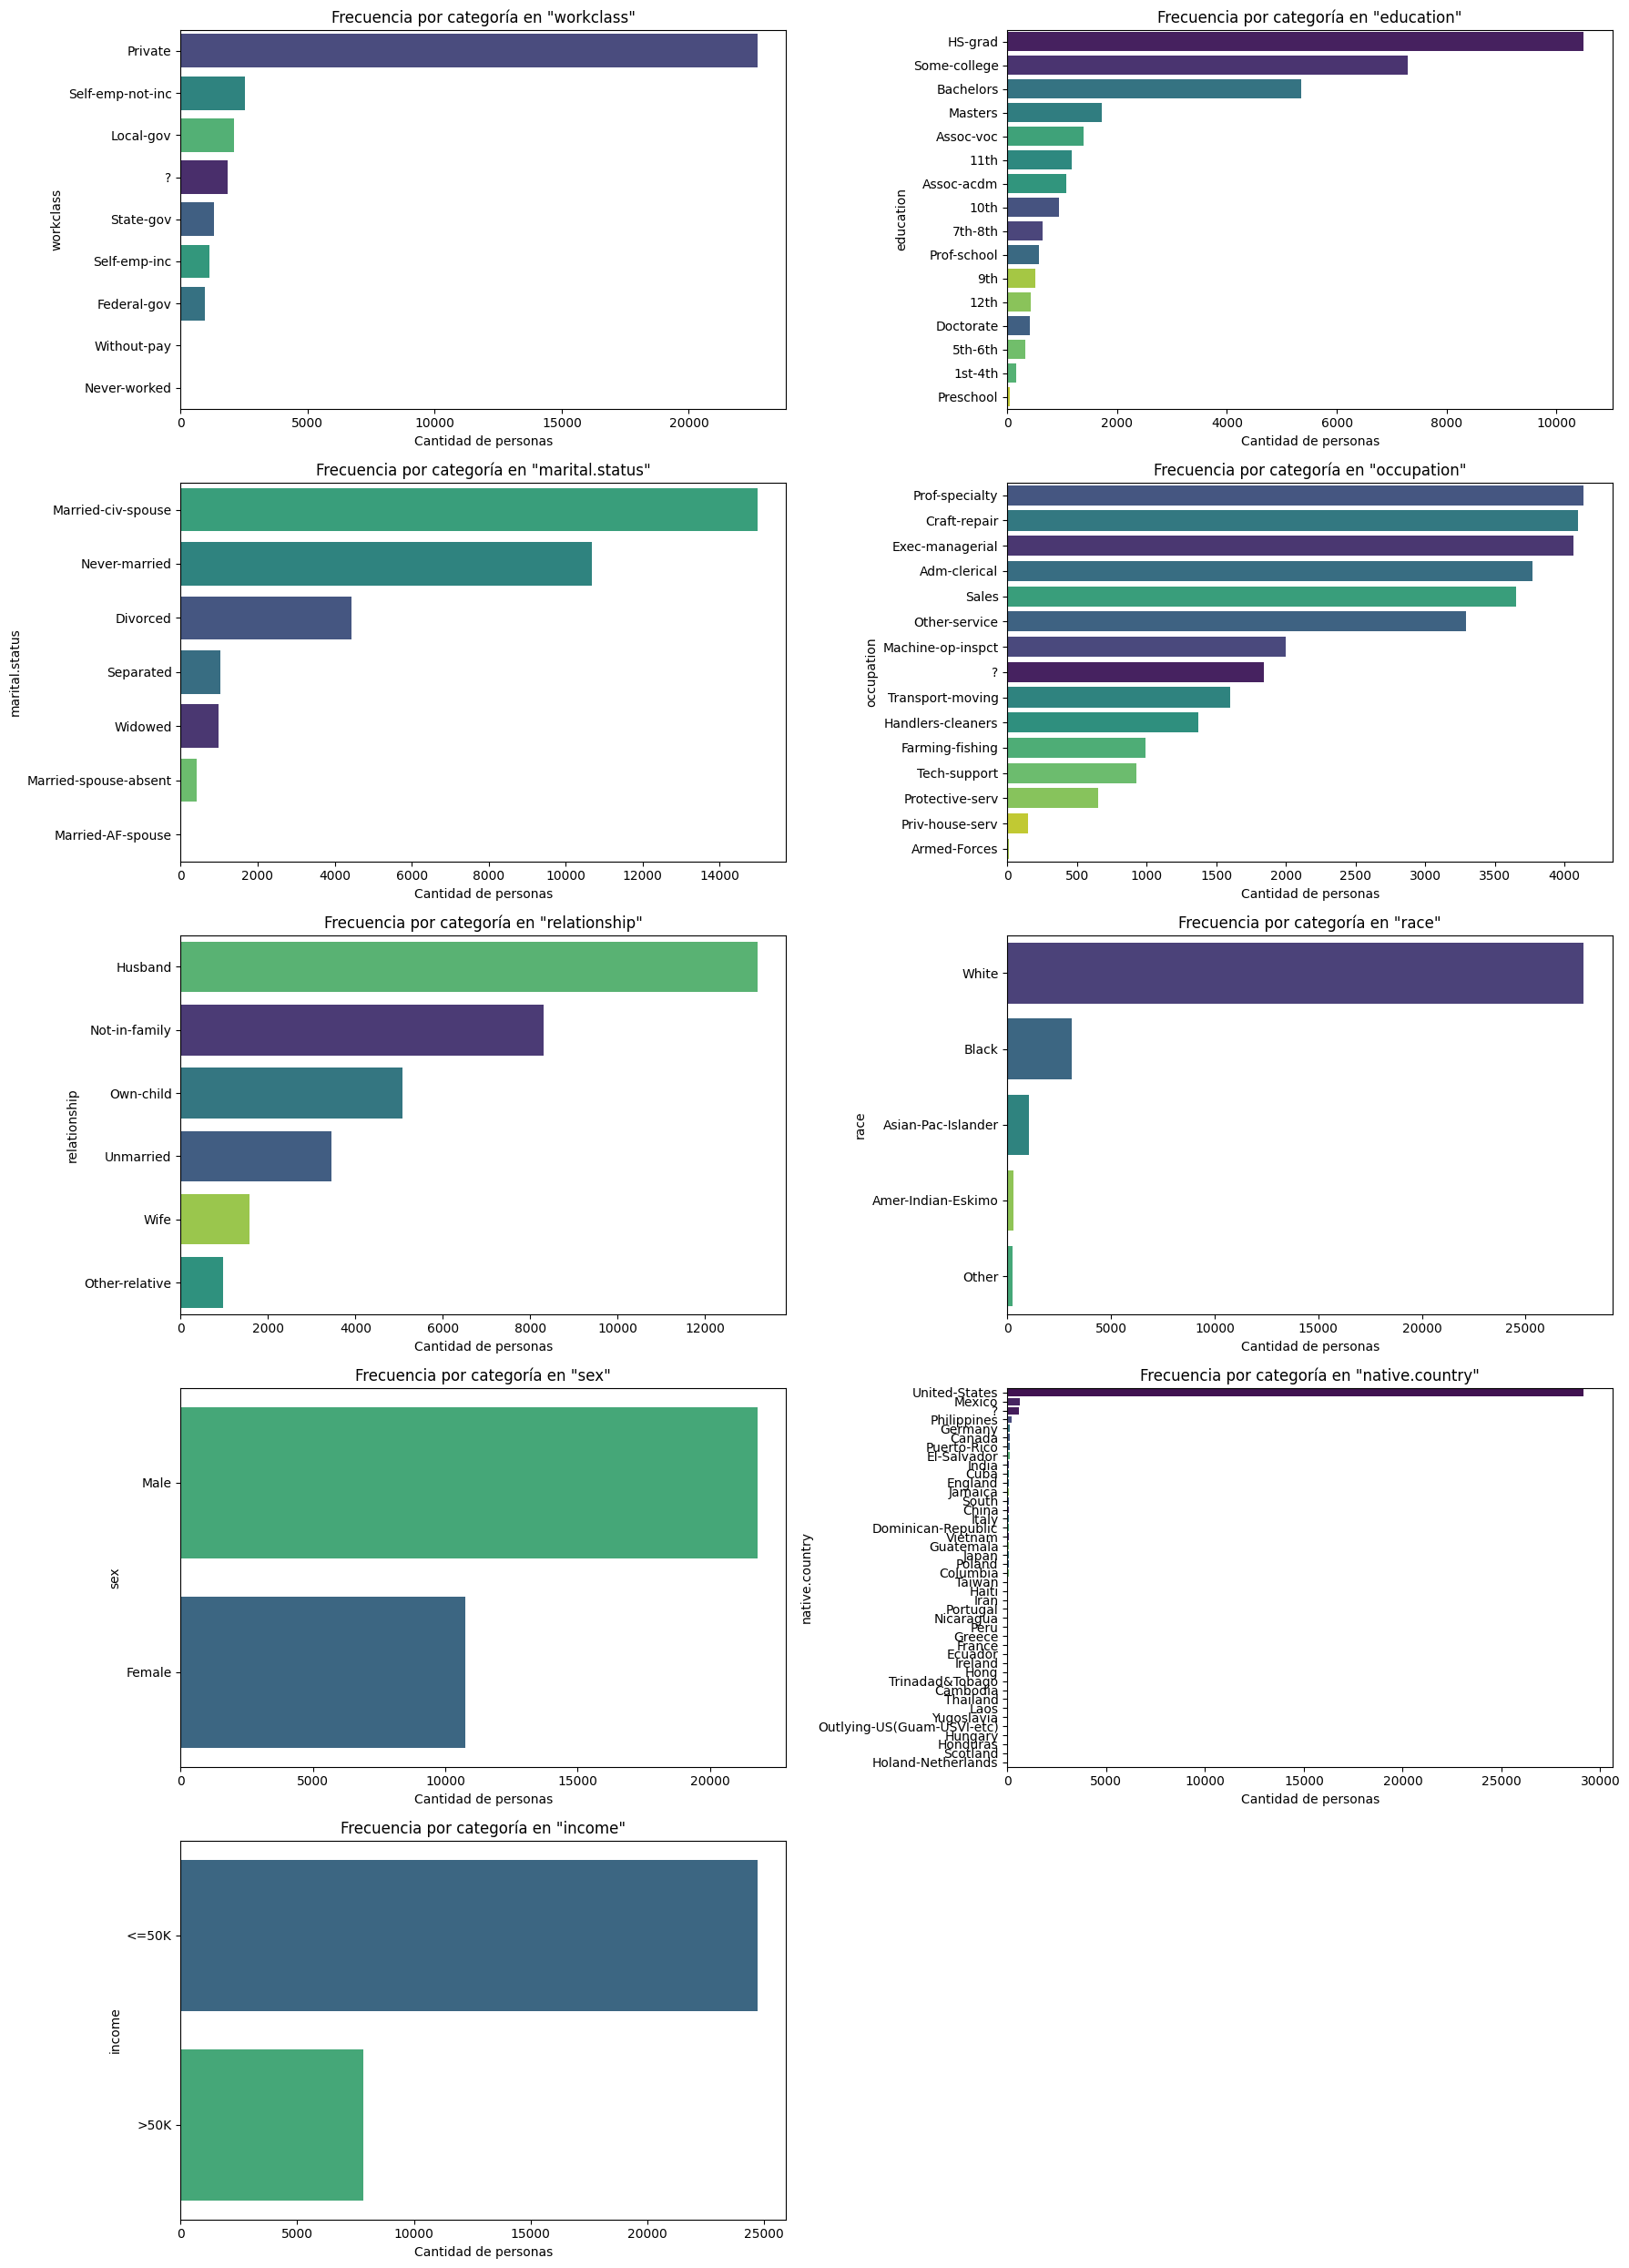

In [17]:
# Definir las variables categóricas del dataset
variables_categoricas = ['workclass', 'education', 'marital.status', 
                         'occupation', 'relationship', 'race', 
                         'sex', 'native.country', 'income']

# Definir el tamaño de la figura
plt.figure(figsize=(18, 25))

# Crear un gráfico de barras para cada variable categórica
for i, var in enumerate(variables_categoricas, 1):
    plt.subplot(5, 2, i)
    sns.countplot(data=census, y=var, hue=var, legend=False,
                  order=census[var].value_counts().index,
                  palette='viridis')
    plt.title(f'Frecuencia por categoría en "{var}"')
    plt.xlabel('Cantidad de personas')
    plt.ylabel(var)

plt.tight_layout()
plt.show()

### Identificación de Parámetros Faltantes y Completado

Los datos faltantes se encuentran en 3 atributos específicamente: ``workclass``, ``occupation`` y ``native.country``. Es necesario primero determinar si las personas con ``workclass`` y ``occupation`` igua a ? son las mismas.

In [18]:
# Crear filtros
filtro_workclass = census['workclass'] == '?'
filtro_occupation = census['occupation'] == '?'

# También contar cuántas filas cumplen ambas condiciones simultáneamente
coinciden_ambos = (filtro_workclass & filtro_occupation).sum()
solo_workclass = (filtro_workclass & ~filtro_occupation).sum()
solo_occupation = (filtro_occupation & ~filtro_workclass).sum()

print("Instancias donde ambos son '?':", coinciden_ambos)
print("Solo workclass es '?':", solo_workclass)
print("Solo occupation es '?':", solo_occupation)


Instancias donde ambos son '?': 1836
Solo workclass es '?': 0
Solo occupation es '?': 7


La diferencia solo son 7 personas, por lo que determinarán el ``workclass`` de estas 7 que difieren.

In [19]:
# Filtrar las instancias donde workclass ≠ '?' y occupation == '?'
filtro = (census['workclass'] != '?') & (census['occupation'] == '?')

# Mostrar las filas que cumplen esta condición
print(census[filtro])


       age     workclass  fnlwgt     education  education.num  \
8874    18  Never-worked  206359          10th              6   
13675   23  Never-worked  188535       7th-8th              4   
17089   17  Never-worked  237272          10th              6   
21934   18  Never-worked  157131          11th              7   
24483   20  Never-worked  462294  Some-college             10   
32331   30  Never-worked  176673       HS-grad              9   
32338   18  Never-worked  153663  Some-college             10   

           marital.status occupation   relationship   race     sex  \
8874        Never-married          ?      Own-child  White    Male   
13675            Divorced          ?  Not-in-family  White    Male   
17089       Never-married          ?      Own-child  White    Male   
21934       Never-married          ?      Own-child  White  Female   
24483       Never-married          ?      Own-child  Black    Male   
32331  Married-civ-spouse          ?           Wife  Black 

Podemos observar que estas personas estan categorizadas en su atributo ``workclass`` como ``Never-Worked`` aún cuando poseen horas semanales destinadas a trabajar: 
- Pueden existir muchas causas por la que estas personas no poseen ocupación registrada, como no poseer un trabajo formal o llevar a cabo tareas domésticas o de voluntariado, lo cual justifica la cantidad de horas trabajadas, pero va en contra de su categoría de ``Never-Worked``.
- También puede ser que estas personas estén desempleadas, y nunca hayan trabajado, motivo por el cual poseen el atributo ``Never-Worked`` y por error se haya cargado una cantidad de hotas semanales de trabajo.

Caulquiera sea el caso, esto representa una inconsistencia en los datos que pueden modificar el desarrollo de un modelo a futuro, por lo que estas instancias no searán consideradas durante el entrenamiento.

Se establece entonces una nueva versión del dataset donde estos datos será eliminados.

In [20]:
# Se crea una copia del dataset original
census_limpio = census.copy()

# Se eliminan las filas donde 'workclass' es igual a 'Never-worked'
census_limpio = census_limpio[census_limpio['workclass'] != 'Never-worked']

# Se imprime la cantidad de filas restantes
print(f"Número de filas después de eliminar 'Never-worked': {census_limpio.shape[0]}")

Número de filas después de eliminar 'Never-worked': 32554


El resto de las personas que poseen ``occupation`` igual a **?**, también poseen ``workclass`` igual a **?**. El siguiente paso será completar dichos valores o determinar si deben ser eliminados del dataset.

Se establece una primer hipótesis: Las personas con ``workclass`` y/o ``occupation`` igual a **?** puede que sean jubilados. Se debe determinar si hay personas que poseen una edad superior a 62 años, que es la edad jubilatoria mínima en USA.

In [21]:
# Se filtran las filas donde occupation y workclass son '?' simultáneamente
filtro = (census_limpio['occupation'] == '?') & (census_limpio['workclass'] == '?')

# Se aplica el filtro junto con la condición de edad > 62
mayores_62 = census_limpio[filtro & (census_limpio['age'] > 62)]

# Se imprime la cantidad de personas que cumplen ambas condiciones
print(f"Número de personas mayores de 62 años con occupation y workclass igual a '?': {len(mayores_62)}")

Número de personas mayores de 62 años con occupation y workclass igual a '?': 415


Dada la cantidad de personas que se ajustan al perfil, se agregará una nueva categoría en ambos denominada ``retired``.

In [22]:
# Se reemplaza '?' por 'Retired' en occupation para personas mayores de 62 años
census.loc[filtro & (census['age'] > 62), 'occupation'] = 'Retired'

# Se reemplaza '?' por 'Retired' en workclass para personas mayores de 62 años
census.loc[filtro & (census['age'] > 62), 'workclass'] = 'Retired'